## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- matplotlib
- The Python standard library
- Jupyter notebooks and nbdev

In [ ]:
%load_ext lab_black

In [2]:
!pip install torch
!pip install fastcore
!pip install numpy
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt
from urllib.request import urlretrieve
from itertools import islice
from random import random
import numpy as np
import torch
from torch import tensor
from fastcore.test import *

from numba import njit, cuda

## Get data

In [4]:
MNIST_URL = "https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true"
path_data = Path("data")
path_data.mkdir(exist_ok=True)
path_gz = path_data / "mnist.pkl.gz"

[urlretrieve](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve) - (read the docs!)

In [5]:
if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [6]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Apr 14 00:16 mnist.pkl.gz


In [8]:
with gzip.open(path_gz, "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [9]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [10]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i : i + sz]

In [11]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

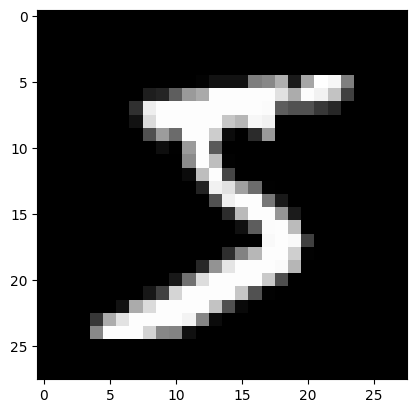

In [12]:
mpl.rcParams["image.cmap"] = "gray"
plt.imshow(list(chunks(lst1, 28)))

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [13]:
it = iter(vals)
islice(it, 5)

In [14]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [15]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [16]:
list(islice(it, 5))

[]

In [17]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

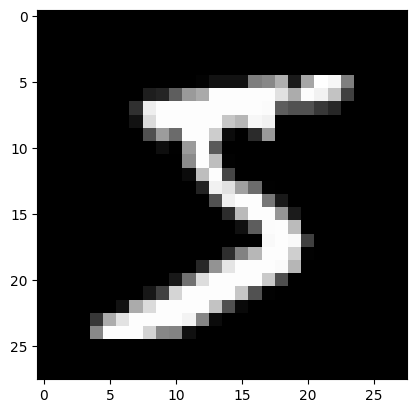

In [18]:
plt.imshow(img)

## Matrix and tensor

In [19]:
img[20][15]

0.98828125

In [20]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs

    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [21]:
m = Matrix(img)
m[20, 15]

0.98828125

In [22]:
tensor([1, 2, 3])

tensor([1, 2, 3])

In [23]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [24]:
x_train.type()

'torch.FloatTensor'

[Tensor](https://pytorch.org/docs/stable/tensors.html)

In [25]:
imgs = x_train.reshape((-1, 28, 28))
imgs.shape

torch.Size([50000, 28, 28])

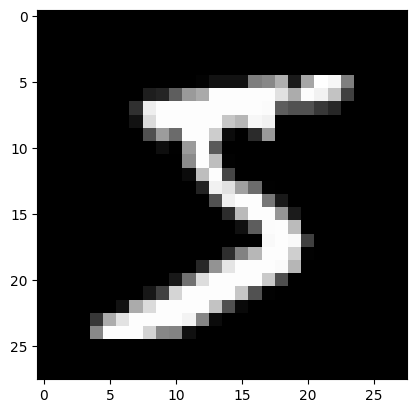

In [26]:
plt.imshow(imgs[0])

In [27]:
imgs[0, 20, 15]

tensor(0.9883)

In [28]:
n, c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [29]:
min(y_train), max(y_train)

(tensor(0), tensor(9))

In [30]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Random numbers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [31]:
rnd_state = None


def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x) + 1, int(y) + 1, int(z) + 1

In [32]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [33]:
# Pseudo random number generator
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x, y, z
    return (x / 30269 + y / 30307 + z / 30323) % 1.0

In [34]:
rand(), rand(), rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [35]:
if os.fork():
    print(f"In parent: {rand()}")
else:
    print(f"In child: {rand()}")
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


The reason for getting the same random number in both the parent and the child process is because they have the same random_state, which is used to generate the random number.

Both `torch` and `numpy` fail at creating different random numbers in both the parent and the child processes. But `Python` works fine.

In [36]:
if os.fork():
    print(f"In parent: {torch.rand(1)}")
else:
    print(f"In child: {torch.rand(1)}")
    os._exit(os.EX_OK)

In parent: tensor([0.6934])
In child: tensor([0.6934])


In [37]:
if os.fork():
    print(f"In parent: {np.random.randn(1)}")
else:
    print(f"In child: {np.random.randn(1)}")
    os._exit(os.EX_OK)

In parent: [-0.46499466]
In child: [-0.46499466]


In [38]:
if os.fork():
    print(f"In parent: {random()}")
else:
    print(f"In child: {random()}")
    os._exit(os.EX_OK)

In parent: 0.20064017145731972
In child: 0.14658143075002028


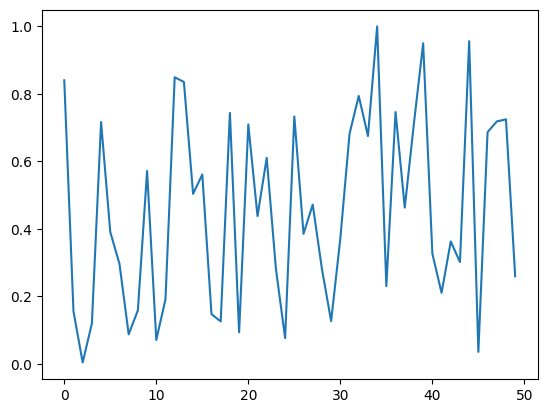

In [39]:
plt.plot([rand() for _ in range(50)])

There is not relationship between random numbers as expected.

(array([ 959.,  972., 1036., 1019., 1037.,  971.,  997., 1000., 1036.,
         973.]),
 array([6.60514437e-06, 1.00005135e-01, 2.00003666e-01, 3.00002196e-01,
        4.00000726e-01, 4.99999256e-01, 5.99997787e-01, 6.99996317e-01,
        7.99994847e-01, 8.99993378e-01, 9.99991908e-01]),
 <BarContainer object of 10 artists>)

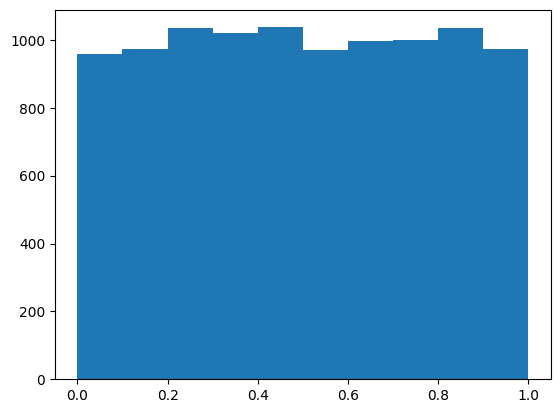

In [40]:
plt.hist([rand() for _ in range(10000)])

As expected, the generated numbers follow closely the standard uniform distribution.

In [41]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.48 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%timeit -n 10 torch.randn(784,10)

143 µs ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


`torch` version is much faster.

## Matrix multiplication

In [43]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [44]:
m1 = x_valid[:5]
m2 = weights

In [45]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [46]:
ar, ac = m1.shape  # n_rows * n_cols
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

In [47]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [48]:
for i in range(ar):  # 5
    for j in range(bc):  # 10
        for k in range(ac):  # 784
            t1[i, j] += m1[i, k] * m2[k, j]

In [49]:
t1

tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

In [50]:
t1.shape

torch.Size([5, 10])

In [51]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [52]:
np.set_printoptions(precision=2, linewidth=140)

In [53]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    return c

In [54]:
%time _=matmul(m1, m2)

CPU times: user 1.35 s, sys: 4.07 ms, total: 1.36 s
Wall time: 1.4 s


In [55]:
ar * bc * ac

39200

## Numba

In [56]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [58]:
%time dot(np.array([1.,2,3]), np.array([2.,3,4]))

CPU times: user 610 ms, sys: 86.6 ms, total: 697 ms
Wall time: 1.02 s


20.0

In [60]:
%time dot(np.array([1.,2,3]),np.array([2.,3,4]))

CPU times: user 33 µs, sys: 6 µs, total: 39 µs
Wall time: 41.7 µs


20.0

Now only two of our loops are running in Python, not three:

In [61]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [62]:
m1a,m2a = m1.numpy(),m2.numpy()

In [63]:
test_close(t1,matmul(m1a, m2a))

In [64]:
%timeit -n 50 matmul(m1a,m2a)

708 µs ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise ops

[TryAPL](https://tryapl.org/)

In [65]:
a = tensor([10.0, 6, -4])
b = tensor([2.0, 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [66]:
a + b

tensor([12., 14.,  3.])

In [67]:
(a < b).float().mean()

tensor(0.67)

In [68]:
m = tensor([[1.0, 2, 3], [4, 5, 6], [7, 8, 9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [69]:
sf = (m * m).sum()
sf

tensor(285.)

In [70]:
sf.sqrt()

tensor(16.88)

In [71]:
m[2, :], m[:, 2]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

In [72]:
m[2]

tensor([7., 8., 9.])

In [73]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

In [74]:
test_close(t1, matmul(m1, m2))

In [75]:
%timeit -n 50 _=matmul(m1, m2)

1.35 ms ± 85.4 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [76]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = torch.dot(a[i, :], b[:, j])
    return c

In [77]:
test_close(t1, matmul(m1, m2))

In [78]:
%timeit -n 50 _=matmul(m1, m2)

1.58 ms ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [79]:
a

tensor([10.,  6., -4.])

In [80]:
a > 0

tensor([ True,  True, False])

How are we able to do `a > 0`?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [81]:
a + 1

tensor([11.,  7., -3.])

In [82]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [83]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

Although broadcasting a scalar is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) a little known language called [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector to a matrix:

In [84]:
c = tensor([10.0, 20, 30])
c

tensor([10., 20., 30.])

In [85]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [86]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [87]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [88]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [89]:
t = c.expand_as(m)

In [90]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [91]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [92]:
t.storage()

<ipython-input-92-9fabd8d8a8f0>:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t.storage()
/usr/local/lib/python3.9/dist-packages/IPython/lib/pretty.py:700: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  output = repr(obj)
/usr/local/lib/python3.9/dist-packages/torch/storage.py:645: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use t

 10.0
 20.0
 30.0
[torch.storage.TypedStorage(dtype=torch.float32, device=cpu) of size 3]

In [93]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [94]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [95]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [96]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [97]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [98]:
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [99]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [100]:
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [101]:
m + c[None, :]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [102]:
c[None, :]

tensor([[10., 20., 30.]])

In [103]:
c[None, :].shape

torch.Size([1, 3])

In [104]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

In [105]:
c[:, None].shape

torch.Size([3, 1])

In [106]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [107]:
c[None] > c[:, None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [108]:
m * m

tensor([[ 1.,  4.,  9.],
        [16., 25., 36.],
        [49., 64., 81.]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting

In [109]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [110]:
digit[:, None].shape

torch.Size([784, 1])

In [111]:
digit[:, None].expand_as(m2).shape

torch.Size([784, 10])

In [112]:
(digit[:, None] * m2).shape

torch.Size([784, 10])

In [113]:
m1[0][..., None].shape

torch.Size([784, 1])

In [114]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        #       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i] = (a[i][..., None] * b).sum(dim=0)  # broadcast version
    return c

In [115]:
test_close(t1, matmul(m1, m2))

In [116]:
%timeit -n 50 _=matmul(m1, m2)

191 µs ± 66.3 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Our time has gone from ~500ms to <0.1ms, an over 5000x improvement! We can run on the whole dataset now.

In [117]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [118]:
tr.shape

torch.Size([50000, 10])

In [119]:
%time _=matmul(x_train, weights)

CPU times: user 2.27 s, sys: 9.58 ms, total: 2.28 s
Wall time: 2.33 s


## Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([`einsum`](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:

- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

In [120]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [121]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
mr = torch.einsum("ik,kj->ikj", m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [122]:
mr.sum(1)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [123]:
torch.einsum("ik,kj->ij", m1, m2)

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [124]:
def matmul(a, b):
    return torch.einsum("ik,kj->ij", a, b)

In [125]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

In [126]:
%timeit -n 5 _=matmul(x_train, weights)

30.5 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [127]:
test_close(tr, x_train @ weights, eps=1e-3)

In [128]:
%timeit -n 5 _=torch.matmul(x_train, weights)

30.9 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## CUDA

In [129]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [130]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[-10.94,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00,   0.00]])

In [131]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): kernel((i,j), *args, **kwargs)

In [132]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [133]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [136]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

In [137]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train,weights,r))

In [138]:
r.shape

(50000, 10)

In [139]:
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [140]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1e-3)

In [141]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

10.9 ms ± 3.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [142]:
m1c,m2c = x_train.cuda(),weights.cuda()

In [143]:
r=(m1c@m2c).cpu()

In [144]:
%timeit -n 10 r=(m1c@m2c).cpu()

2.21 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!